# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [29]:
# Imports here
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [21]:
# Sets the file paths for the directories containing the training, 
# validation, and testing data.

data_dir = '/home/ubuntu/flowers' # Edit this if training remotely vs locally
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [22]:
# TODO: Define your transforms for the training, validation, and testing 
# sets
"""
Define data transformations, load datasets, and define dataloaders.

This code block defines the following:
- `data_transforms`: A dict that contains the data transformations 
    for the training, validation, and testing sets.

- `image_datasets`: A dict that contains the datasets loaded using 
    the `ImageFolder` class from the `datasets` module.

- `dataloaders`: A dict that contains the dataloaders for the 
    training, validation, and testing sets.

The data transformations include random rotation, random resized crop, 
random horizontal flip, tensor conversion, and normalisation. 

The datasets are loaded using the `ImageFolder` class, which expects the
directory structure to be organised by class labels. The dataloaders are 
created using the `DataLoader` class, which provides an iterable over 
the datasets with specified batch sizes.
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=64),
    'test': DataLoader(image_datasets['test'], batch_size=64)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [54]:
# Opens the 'cat_to_name.json' file in read mode and loads its contents 
# into a dictionary that maps category labels to flower names.
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Cell to verify hardware being used before commencing

In [5]:
# Verify the hardware being used

def get_device():
    # Check for CUDA (NVIDIA GPU)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using NVIDIA GPU with CUDA.")

# Check for ROCm (AMD GPU)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using AMD GPU with ROCm.")
    
# Fallback to CPU
    else:
        device = torch.device("cpu")
        print("Using CPU.")

    return device

# call the function
device = get_device()


Using CPU.


In [27]:
# Load a pre-trained model
model = models.vgg16(pretrained=True)


/home/ubuntu/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [00:01<00:00, 357MB/s]


In [28]:
# Freeze the parameters of the pre-trained model to avoid backpropagation through them
for param in model.parameters():
    param.requires_grad = False


In [29]:
# Define a new, untrained feed-forward network as a classifier
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 102),
    nn.LogSoftmax(dim=1)
)

# Replace the pre-trained model's classifier with the new classifier
model.classifier = classifier

# Move the model to the appropriate device (GPU/CPU)
model = model.to(device)


In [30]:
# Specify the loss function and optimiser
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.classifier.parameters(), lr=0.001)


In [31]:
# Train the classifier
model.train()

# Set the number of epochs
epochs = 5
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for inputs, labels in dataloaders['train']:
        steps += 1

        # Move input and label tensors to the appropriate device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimiser.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            # Validate the model
            model.eval()
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in dataloaders['valid']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Calculate the accuracy
                    ps = torch.exp(outputs)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f'Epoch {epoch+1}/{epochs}.. '
                  f'Train loss: {running_loss/print_every:.3f}.. '
                  f'Validation loss: {loss:.3f}.. '
                  f'Validation accuracy: {accuracy/len(dataloaders["valid"]):.3f}')
            
            running_loss = 0
            model.train()


Epoch 1/5.. Train loss: 9.465.. Validation loss: 12.231.. Validation accuracy: 0.056
Epoch 1/5.. Train loss: 9.920.. Validation loss: 9.592.. Validation accuracy: 0.142
Epoch 1/5.. Train loss: 6.477.. Validation loss: 6.308.. Validation accuracy: 0.302
Epoch 1/5.. Train loss: 4.106.. Validation loss: 3.290.. Validation accuracy: 0.343
Epoch 1/5.. Train loss: 3.203.. Validation loss: 2.843.. Validation accuracy: 0.433
Epoch 1/5.. Train loss: 3.227.. Validation loss: 2.752.. Validation accuracy: 0.494
Epoch 1/5.. Train loss: 2.784.. Validation loss: 2.921.. Validation accuracy: 0.562
Epoch 1/5.. Train loss: 2.573.. Validation loss: 2.182.. Validation accuracy: 0.601
Epoch 1/5.. Train loss: 2.303.. Validation loss: 1.760.. Validation accuracy: 0.631
Epoch 1/5.. Train loss: 2.322.. Validation loss: 2.140.. Validation accuracy: 0.650
Epoch 1/5.. Train loss: 2.088.. Validation loss: 1.421.. Validation accuracy: 0.698
Epoch 1/5.. Train loss: 1.883.. Validation loss: 1.623.. Validation accurac

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [36]:
# TODO: Do validation on the test set

# Set the model to evaluation mode
model.eval()

# Initialise test accuracy and number of samples
test_accuracy = 0
num_samples = 0

# Disable gradient computation as not required for validation
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        # Move inputs and labels to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate probabilities
        ps = torch.exp(outputs)
        
        # Get the top class
        top_p, top_class = ps.topk(1, dim=1)
        
        # Compare predicted classes with true labels
        equals = top_class == labels.view(*top_class.shape)
        
        # Calculate accuracy for the batch and accumulate
        batch_accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        test_accuracy += batch_accuracy * inputs.size(0)
        
        # Accumulate the number of samples
        num_samples += inputs.size(0)

# Calculate the overall accuracy on the test set
test_accuracy = test_accuracy / num_samples
print(f"Test Accuracy: {test_accuracy:.3f}")


Test Accuracy: 0.857


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimiser state, `optimiser.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [51]:
# TODO: Save the checkpoint 

# Save the model
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    'model_architecture': model_architecture,
    'input_size': 25088,
    'output_size': 102,
    'hidden_layers': [4096],
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'classifier': model.classifier,
    'optimiser_state_dict': optimiser.state_dict(),
    'epochs': epochs
}

torch.save(checkpoint, 'checkpoint.pth')



"""Note: If the model was trained remotely as described in the
remote_gpu_training.md model, then it will save on the remote instance.
Be sure to download the model to your local machine using the following
command: 

scp -i "your-key.pem" ubuntu@your-remote-ip:/path/to/checkpoint.pth /path/to/save/checkpoint.pth

or scp -r -i ... for directories.

Replace "your-key.pem" with the path to your private key file,
"your-remote-ip" with the IP address of your remote instance,
"/path/to/checkpoint.pth" with the path to the model on the remote instance,
and "/path/to/save/checkpoint.pth" with the path where you want to save the model on your local machine.

If you don't do this, then the model will be lost when the remote 
instance is terminated (if there is no persistent storage).
"""

'Note: If the model was trained remotely as described in the\nremote_gpu_training.md model, then it will save on the remote instance.\nBe sure to download the model to your local machine using the following\ncommand: \n\nscp -i "your-key.pem" ubuntu@your-remote-ip:/path/to/checkpoint.pth /path/to/save/checkpoint.pth\n\nor scp -r -i ... for directories.\n\nReplace "your-key.pem" with the path to your private key file,\n"your-remote-ip" with the IP address of your remote instance,\n"/path/to/checkpoint.pth" with the path to the model on the remote instance,\nand "/path/to/save/checkpoint.pth" with the path where you want to save the model on your local machine.\n\nIf you don\'t do this, then the model will be lost when the remote \ninstance is terminated (if there is no persistent storage).\n'

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath, model_architecture='vgg16', load_optimiser=True):
    """
    Load a model checkpoint and rebuild the model.

    Args:
    - filepath (str): Path to the checkpoint file.
    - model_architecture (str): Model architecture type (e.g., 'vgg16').
    - load_optimiser (bool): Whether to load the optimiser state from the checkpoint.

    Returns:
    - model (torch.nn.Module): Rebuilt model loaded with checkpoint parameters.
    - optimiser (torch.optim.optimiser or None): Optimiser loaded with checkpoint parameters, or None.
    - epochs (int): Number of epochs the model was trained for.
    """

    # Get the device based on available hardware
    device = get_device()

    # Load the checkpoint, explicitly specifying weights_only=False for clarity
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)
    
    # Rebuild the model based on the architecture stored in the checkpoint
    if model_architecture == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier = checkpoint['classifier']  # Load the classifier
    else:
        raise ValueError(f"Model architecture '{model_architecture}' is not supported.")
    
    # Load the state dict into the model
    model.load_state_dict(checkpoint['state_dict'])
    
    # Load class_to_idx
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Rebuild the optimiser if needed
    optimiser = None
    if load_optimiser:
        try:
            optimiser = torch.optim.Adam(model.parameters())
            optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        except ValueError as e:
            print(
                "Warning: Failed to load optimiser state due to a parameter mismatch.\n" 
                f"Reason: {e}\n"
                "\n"
                "This could affect training in the following ways:\n"
                "1. If you are resuming training after a long session or with a complex model,\n" 
                "   starting with a fresh optimiser might cause the model to lose some momentum.\n"
                "   This could lead to slower convergence or different training dynamics.\n"
                "\n"
                "2. If you are fine-tuning or performing inference, this generally won't matter as much,\n" 
                "   and the model's weights are still loaded correctly.\n"
                "\n"
                "A new optimiser has been reinitialised with default settings."
            )

            optimiser = torch.optim.Adam(model.parameters())  # Reinitialise optimiser if loading failed
    
    # Load the number of epochs
    epochs = checkpoint['epochs']

    return model, optimiser, epochs

# Example of using load_checkpoint()
model, optimiser, epochs = load_checkpoint('checkpoint.pth', model_architecture='vgg16', load_optimiser=True)

Using CPU.
Reason: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

This could affect training in the following ways:
1. If you are resuming training after a long session or with a complex model,
   starting with a fresh optimiser might cause the model to lose some momentum.
   This could lead to slower convergence or different training dynamics.

2. If you are fine-tuning or performing inference, this generally won't matter as much,
   and the model's weights are still loaded correctly.

A new optimiser has been reinitialised with default settings.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [66]:
# TODO: Process a PIL image for use in a PyTorch model

def process_image(image_path):
    """
    Scales, crops, and normalises a PIL image for a PyTorch model,
    returns a Numpy array.
    
    Args:
    - image_path (str): Path to the image file.
    
    Returns:
    - np_image (np.ndarray): Processed image as a Numpy array.
    """
    
    # Load the image
    pil_image = Image.open(image_path)

    # Display the original image
    #plt.figure(figsize=(6, 6))
    #plt.imshow(pil_image)
    #plt.title("Original Image")
    #plt.axis('off')
    #plt.show()
    
    # Resize the image so the shortest side is 256 pixels
    size = 256
    aspect_ratio = pil_image.size[0] / pil_image.size[1]
    if aspect_ratio > 1:
        new_size = (int(aspect_ratio * size), size)
    else:
        new_size = (size, int(size / aspect_ratio))
    
    pil_image = pil_image.resize(new_size, Image.LANCZOS)
    
    # Center crop the image to 224x224
    width, height = pil_image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = left + 224
    bottom = top + 224
    pil_image = pil_image.crop((left, top, right, bottom))
    
    # Convert image to Numpy array and normalise
    np_image = np.array(pil_image) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Reorder dimensions so that color channel is first
    np_image = np_image.transpose((2, 0, 1))

    # Display a sample of the resulting array
    #print("Sample of the resulting array:")
    #print(np_image[:, :5, :5])  # Displaying the first 5x5 block of each channel
    
    return np_image

# Process image
image_path = 'flowers/test/1/image_06743.jpg'
processed_image = process_image(image_path)

# Convert processed image to PyTorch tensor
image_tensor = torch.tensor(processed_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

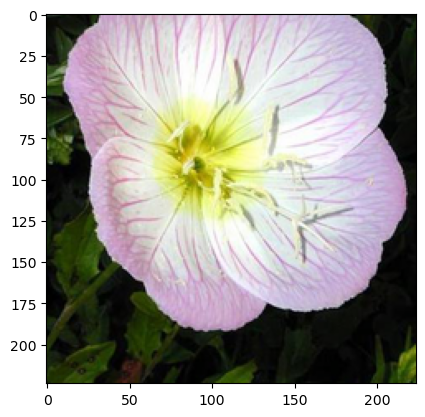

In [67]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(image_tensor);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [68]:
def predict(image_path, model, topk=5):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
    - image_path (str): Path to the image file.
    - model (torch.nn.Module): Trained PyTorch model for prediction.
    - topk (int): Number of top most likely classes to return.
    
    Returns:
    - probs (list): Probabilities of the top K classes.
    - classes (list): Corresponding classes for the top K probabilities.
    """
    
    # Process the image
    np_image = process_image(image_path)
    
    # Convert to PyTorch tensor and add batch dimension
    image_tensor = torch.from_numpy(np_image).unsqueeze(0).float()
    
    # Set model to evaluation mode
    model.eval()
    
    # Disable gradients for inference
    with torch.no_grad():
        output = model.forward(image_tensor)
    
    # Apply softmax to get probabilities
    probs = torch.softmax(output, dim=1)
    
    # Get the top K probabilities and classes
    top_probs, top_indices = torch.topk(probs, topk)
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]
    
    return top_probs, top_classes

probs, classes = predict(image_path, model, topk=5)
print()
print(f"The probabilities are: {probs}")
print(f"The top K classes are: {classes}")
    # TODO: Implement the code to predict the class from an image file


The probabilities are: [9.9362129e-01 5.0136056e-03 6.6699251e-04 2.7570149e-04 2.0508315e-04]
The top K classes are: ['1', '76', '86', '83', '89']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

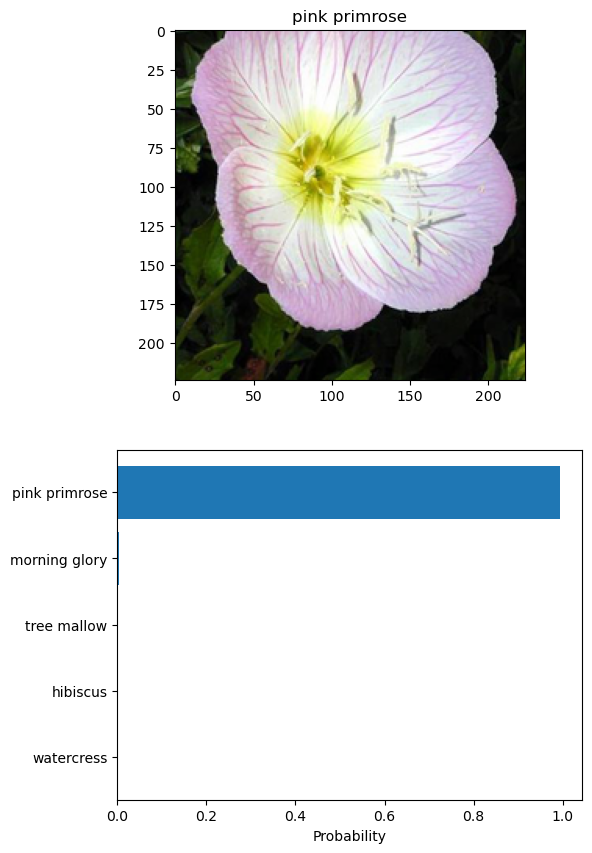

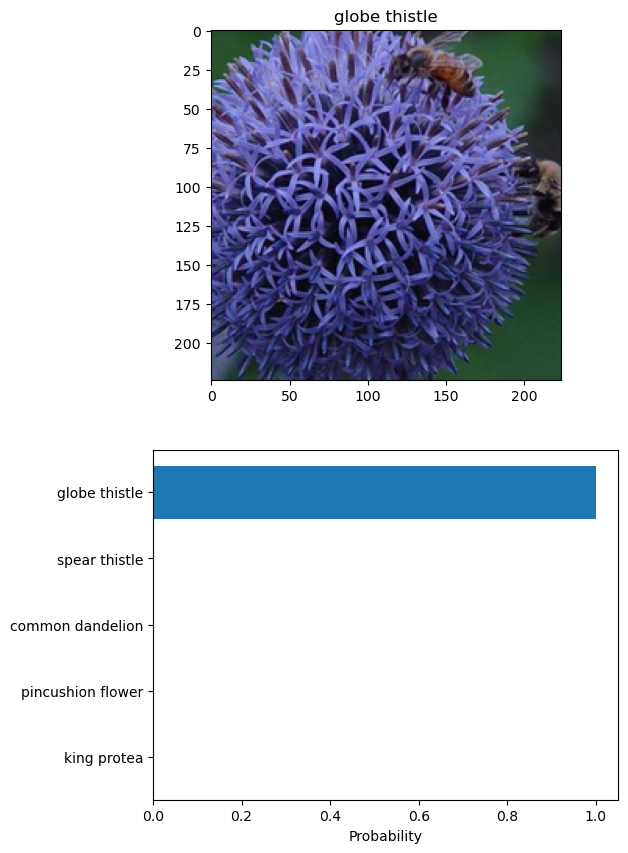

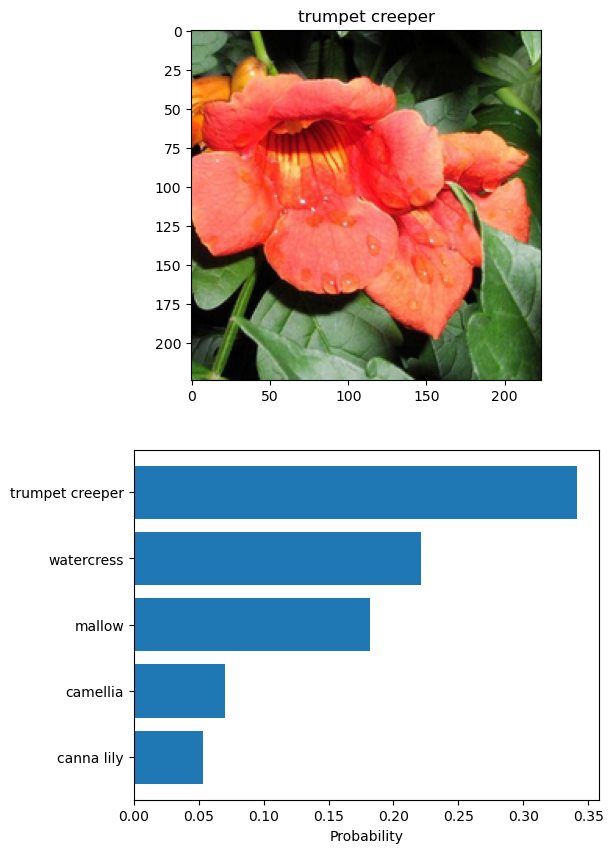

In [71]:
# TODO: Display an image along with the top 5 classes
%matplotlib inline

def sanity_check(image_path, model, cat_to_name, topk=5):
    """
    Perform a sanity check by visualizing the model's top K predictions
    alongside the actual image.
    
    Args:
    - image_path (str): Path to the image file.
    - model (torch.nn.Module): Trained PyTorch model for prediction.
    - cat_to_name (dict): Mapping from class indices to flower names.
    - topk (int): Number of top most likely classes to visualize.
    """
    
    # Make predictions
    probs, classes = predict(image_path, model, topk)
    
    # Convert class indices to flower names
    flower_names = [cat_to_name[cls] for cls in classes]
    
    # Display the image
    plt.figure(figsize=(6, 10))
    ax = plt.subplot(2, 1, 1)
    image_tensor = torch.tensor(process_image(image_path))
    imshow(image_tensor, ax=ax)
    ax.set_title(flower_names[0])  # Title with the top predicted flower name
    
    # Plot the probabilities
    plt.subplot(2, 1, 2)
    y_pos = np.arange(len(flower_names))
    plt.barh(y_pos, probs, align='center')
    plt.yticks(y_pos, flower_names)
    plt.xlabel('Probability')
    plt.gca().invert_yaxis()  # Invert y-axis so the highest probability is at the top
    
    plt.show()

image_path = 'flowers/test/1/image_06743.jpg'
sanity_check(image_path, model, cat_to_name, topk=5)
print()

image_path = 'flowers/test/10/image_07090.jpg'
sanity_check(image_path, model, cat_to_name, topk=5)
print()

image_path = 'flowers/test/101/image_07949.jpg'
sanity_check(image_path, model, cat_to_name, topk=5)
print()